In [1]:
import numpy as np
import matplotlib.pyplot as plt

from auxiliary import values as v
from auxiliary.utils.colors import bcolors as c
from auxiliary.data import imaging

from filtering import cardiac_region as cr
from feature_extraction.feature_extractor import filter_by_margin, filter_by_volume

Label smoothing

In [2]:
img_path = v.data_path + 'Gr4/Segmentation/Nuclei/20190806_E6_nuclei_mask_None.nii.gz'
img =  imaging.read_image(img_path, axes='XYZ', verbose=1)
print(img.shape)

Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr4/Segmentation/Nuclei/20190806_E6_nuclei_mask_None.nii.gz
(1024, 1024, 548)


In [13]:
img_path_out = img_path.replace('.nii.gz', '_smoothed.nii.gz')

import numpy as np
import scipy.ndimage as ndi
from scipy.stats import mode as scimode

def label_preserving_median_filter(segmentation_mask, size=3):
    # Create an output array to hold the filtered labels
    filtered_segmentation = np.zeros_like(segmentation_mask)

    # Get the shape of the image
    shape = segmentation_mask.shape

    # Define the neighborhood size
    footprint = np.ones((size, size, size), dtype=bool)

    # Apply the median filter by processing each voxel
    for index, _ in np.ndenumerate(segmentation_mask):
        # Extract the neighborhood
        slices = tuple(slice(max(0, i - size // 2), min(s, i + size // 2 + 1)) for i, s in zip(index, shape))
        neighborhood = segmentation_mask[slices]

        # Determine the mode (most common label) in the neighborhood
        filtered_segmentation[index] = scimode(neighborhood).mode[0][0]

    return filtered_segmentation

# Example usage:
# segmentation_mask: a 3D numpy array representing the instance segmentation
smoothed_segmentation = label_preserving_median_filter(img, size=3)
imaging.save_nii(smoothed_segmentation, img_path_out, verbose=1)

KeyboardInterrupt: 

In [ ]:
from skimage import restoration
import numpy as np

def anisotropic_diffusion_filter(segmentation_mask, num_iter=10, kappa=50, gamma=0.1):
    """
    Applies anisotropic diffusion to a label image for edge-preserving smoothing.

    Parameters:
    - segmentation_mask: 3D numpy array, the labeled segmentation image.
    - num_iter: Number of iterations to run the diffusion process.
    - kappa: Conductance coefficient, controls sensitivity to edges.
    - gamma: Controls the rate of diffusion.

    Returns:
    - Smoothed segmentation mask.
    """
    smoothed_segmentation = restoration.denoise_tv_chambolle(segmentation_mask, weight=kappa, max_num_iter=num_iter)
    return smoothed_segmentation

# Example usage:
# segmentation_mask: a 3D numpy array representing the instance segmentation
smoothed_segmentation = anisotropic_diffusion_filter(img, num_iter=3, kappa=50, gamma=0.1)


In [ ]:
imaging.save_nii(smoothed_segmentation, img_path_out, verbose=1)

Manual mode filter for label smoothing

Binary mask over segmented image
Median/Gaussian filter over the binary mask
Multiply the filtered binary mask with the segmented image

In [ ]:
# from scipy.ndimage import median_filter
# from scipy.ndimage import gaussian_filter
# 
# def manual_mode_filter(segmentation_mask, binary_mask, size=3, sigma=1):
#     # Create an output array to hold the filtered labels
#     filtered_segmentation = np.zeros_like(segmentation_mask)
# 
#     # Apply the median filter by processing each voxel
#     for index, _ in np.ndenumerate(segmentation_mask):
#         # Extract the neighborhood
#         slices = tuple(slice(max(0, i - size // 2), min(s, i + size // 2 + 1)) for i, s in zip(index, segmentation_mask.shape))
#         neighborhood = segmentation_mask[slices]
# 
#         # Determine the mode (most common label) in the neighborhood
#         filtered_segmentation[index] = scimode(neighborhood).mode[0][0]
# 
#     # Apply the gaussian filter to the binary mask
#     filtered_binary = gaussian_filter(binary_mask, sigma=sigma)
# 
#     # Multiply the filtered binary mask with the filtered segmentation
#     filtered_segmentation = filtered_segmentation * filtered_binary
# 
#     return filtered_segmentation

CROP WITH METADATA

In [3]:
img_path = v.data_path + 'Gr4/RawImages/Nuclei/20190806_E6_DAPI_decon_0.5.nii.gz'
lines_path = v.data_path + 'Gr4/Segmentation/LinesTissue/line_20190806_E6.nii.gz'

margins = cr.get_margins(
    lines_path, img_path=img_path, tissue=['myocardium', 'splanchnic'], verbose=1
)
img = imaging.read_image(img_path, axes='XYZ', verbose=1)
img = cr.crop_img(img, margins, verbose=1)

metadata, affine = imaging.load_metadata(img_path)

imaging.save_nii(img, 'crop_test.nii.gz', affine=affine, verbose=1)

Margin around line: 10
Line metadata: {'x_size': 1024, 'y_size': 1024, 'z_size': 548, 'x_res': 0.924324, 'y_res': 0.924324, 'z_res': 0.79905}
Line shape: (1024, 1024, 548)
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr4/RawImages/Nuclei/20190806_E6_DAPI_decon_0.5.nii.gz
Cropped image shape: (915, 539, 359)

Saving prediction: crop_test.nii.gz


MEMBRANES

In [7]:
masks = imaging.read_tiff(
    v.data_path + 'Gr7/RawImages/Membrane/PreProcessing/confocal_3D_unet_sa_meristem_cells/GASP/PostProcessing/20190403_E2_mGFP_decon_0.5_predictions_gasp_average.tiff',
    axes='ZYX',
    verbose=1
)
print(masks.shape)

Reading TIFF: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr7/RawImages/Membrane/PreProcessing/confocal_3D_unet_sa_meristem_cells/GASP/PostProcessing/20190403_E2_mGFP_decon_0.5_predictions_gasp_average.tiff
(1024, 1024, 490)


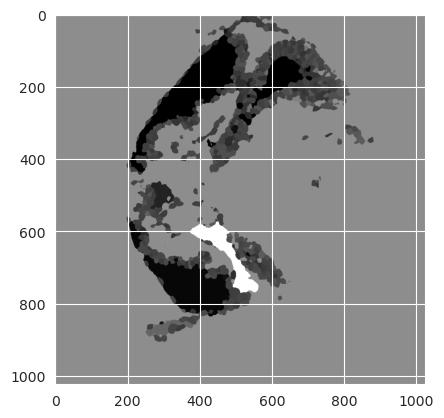

In [8]:
plt.imshow(masks[..., 100], cmap='gray')

In [9]:
masks = filter_by_volume(masks[..., 100:150], verbose=1)

Filtering by volume...
	Found 2546  cells
	Removing 91 cells...



Saving prediction: mask_test.tiff


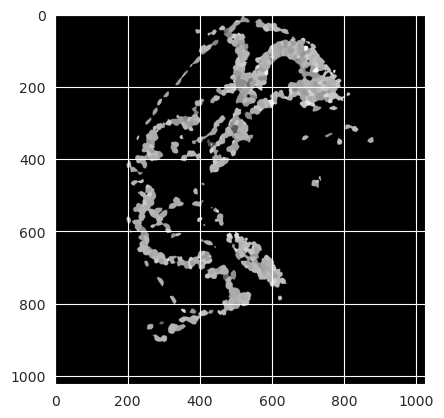

In [11]:
plt.imshow(masks[..., 0], cmap='gray')
imaging.save_prediction(masks, 'mask_test.tiff', verbose=1)

In [14]:
img_path = v.data_path + 'Gr1/Segmentation/Nuclei/20190208_E2_mask_PLACEHOLDER.nii.gz'
img = imaging.read_image(img_path, axes='ZYX', verbose=1)

Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/Segmentation/Nuclei/20190208_E2_mask_PLACEHOLDER.nii.gz


PSEUDO LABELS

In [2]:
import pandas as pd
import os
import sys 

from cell_division.nets.transfer_learning import CNN
from cell_division.semi_supervised import pseudo_labeling

from auxiliary.data.dataset_cell import CellDataset
from auxiliary.data.dataset_unlabeled import UnlabeledDataset
from auxiliary.utils import visualizer as vis

from sklearn.metrics import classification_report, confusion_matrix

In [3]:
img_dir = v.data_path + 'CellDivision/images_nuclei/'
img_dir_unlabeled = v.data_path + 'CellDivision/images_unlabeled/'

label_train_dir = v.data_path + 'CellDivision/undersampled/train.csv'
label_test_dir = v.data_path + 'CellDivision/undersampled/test.csv'
label_val_dir = v.data_path + 'CellDivision/undersampled/val.csv'

INPUT_SHAPE = (100, 100, 3)
BATCH_SIZE = 16

In [29]:
train_generator = CellDataset(
    img_dir, 
    label_train_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

val_generator = CellDataset(
    img_dir, 
    label_val_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

test_generator = CellDataset(
    img_dir, 
    label_test_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

unlabeled_generator = UnlabeledDataset(
    img_dir_unlabeled,
    batch_size=1,
    resize=INPUT_SHAPE[:2]
)

In [8]:
model_semi = CNN()
model_semi.load('../models/cellular_division_models/vgg16_semi.h5')
# model.load('../models/cellular_division_models/vgg16_nuclei_under.h5')

8/8 [==============================] - 3s 430ms/step - loss: 0.6249 - auc: 0.9461
                    precision    recall  f1-score   support

Prophase/Metaphase       0.75      0.95      0.84        42
Anaphase/Telophase       0.88      0.71      0.79        42
        Interphase       0.93      0.86      0.89        43

          accuracy                           0.84       127
         macro avg       0.85      0.84      0.84       127
      weighted avg       0.85      0.84      0.84       127



<Figure size 1200x1200 with 0 Axes>

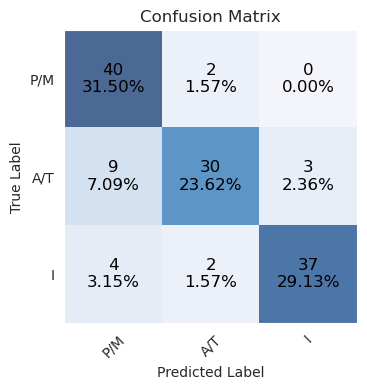

In [9]:
model_semi.model.evaluate(train_generator)
model_semi.model.evaluate(val_generator)
model_semi.model.evaluate(test_generator)

pred = model_semi.model.predict(test_generator).round().astype(int)

print(
    classification_report(
        test_generator.img_labels, [test_generator.oh2class(p) for p in pred], 
        target_names=test_generator.CLASS_NAMES,
        zero_division=0
    )
)

cf_matrix = confusion_matrix(
   test_generator.img_labels, [test_generator.oh2class(p) for p in pred]
)

plt.figure(figsize=(12, 12))
vis.plot_confusion_matrix(cf_matrix)

In [13]:
model_nuclei = CNN()
# model_nuclei.load('../models/cellular_division_models/vgg16_semi.h5')
model_nuclei.load('../models/cellular_division_models/vgg16_nuclei_under.h5')

8/8 [==============================] - 3s 405ms/step - loss: 0.6814 - auc: 0.9435
                    precision    recall  f1-score   support

Prophase/Metaphase       0.89      0.81      0.85        42
Anaphase/Telophase       0.82      0.86      0.84        42
        Interphase       0.87      0.91      0.89        43

          accuracy                           0.86       127
         macro avg       0.86      0.86      0.86       127
      weighted avg       0.86      0.86      0.86       127



<Figure size 1200x1200 with 0 Axes>

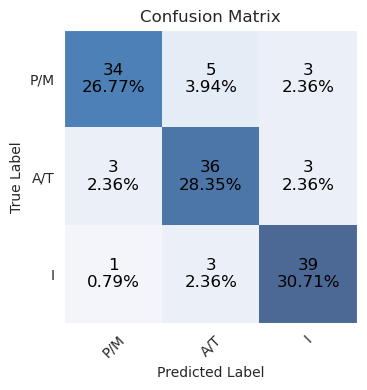

In [14]:
model_nuclei.model.evaluate(train_generator)
model_nuclei.model.evaluate(val_generator)
model_nuclei.model.evaluate(test_generator)

pred = model_nuclei.model.predict(test_generator).round().astype(int)

print(
    classification_report(
        test_generator.img_labels, [test_generator.oh2class(p) for p in pred], 
        target_names=test_generator.CLASS_NAMES,
        zero_division=0
    )
)

cf_matrix = confusion_matrix(
   test_generator.img_labels, [test_generator.oh2class(p) for p in pred]
)

plt.figure(figsize=(12, 12))
vis.plot_confusion_matrix(cf_matrix)

In [15]:
pseudo_labeling(
    model_nuclei, unlabeled_generator,
    threshold=.9, verbose=1
)

Pseudo-labeling results
Pseudo-labels: 0
Pseudo-labels distribution: []


ValueError: Found array with 0 sample(s) while a minimum of 1 is required.

In [10]:
pseudo_labeling(
    model_semi, unlabeled_generator,
    threshold=.9, verbose=1
)

Pseudo-labeling results
Pseudo-labels: 928
Pseudo-labels distribution: [420 148 360]
Undersampling results
Pseudo-labels: 444
Pseudo-labels distribution: [148 148 148]


In [16]:
from cell_division.nets.custom_layers import ExtendedLSEPooling, extended_w_cel_loss
import tensorflow as tf

model = CNN(
    base=tf.keras.applications.VGG16,
    input_shape=INPUT_SHAPE,
    n_classes=3
)
model.build_top(activation='softmax', b_type='CAM', pooling=ExtendedLSEPooling)
model.compile(
    lr=.001,
    loss=extended_w_cel_loss()
)

Epoch 1/100
26/26 [==============================] - 13s 496ms/step - loss: 0.6686 - auc: 0.9582 - val_loss: 0.5664 - val_auc: 0.9603 - lr: 1.0000e-06
Epoch 2/100
26/26 [==============================] - 13s 507ms/step - loss: 0.6838 - auc: 0.9590 - val_loss: 0.5816 - val_auc: 0.9582 - lr: 1.0000e-06
Epoch 3/100
26/26 [==============================] - 13s 486ms/step - loss: 0.7648 - auc: 0.9544 - val_loss: 0.5992 - val_auc: 0.9584 - lr: 1.0000e-06
Epoch 4/100
26/26 [==============================] - 13s 511ms/step - loss: 0.7923 - auc: 0.9472 - val_loss: 0.6176 - val_auc: 0.9551 - lr: 1.0000e-06
Epoch 5/100
26/26 [==============================] - 13s 498ms/step - loss: 0.6530 - auc: 0.9543 - val_loss: 0.6363 - val_auc: 0.9550 - lr: 1.0000e-06
Epoch 6/100
26/26 [==============================] - 13s 513ms/step - loss: 0.8721 - auc: 0.9406 - val_loss: 0.6544 - val_auc: 0.9541 - lr: 1.0000e-06
Epoch 6: early stopping


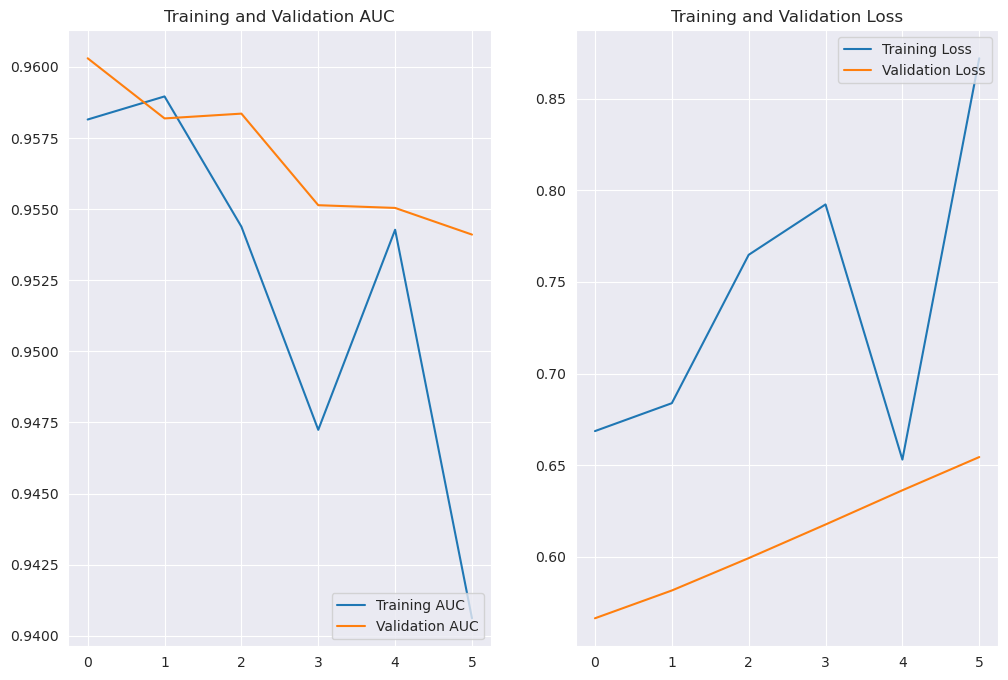

In [24]:
model.fit(
    train_generator,
    val_generator,
    epochs=100,
    verbose=2
)
# model.model.save('../models/cellular_division_models/vgg16_final.h5')

8/8 [==============================] - 3s 394ms/step - loss: 0.5939 - auc: 0.9483
                    precision    recall  f1-score   support

Prophase/Metaphase       0.92      0.79      0.85        42
Anaphase/Telophase       0.84      0.86      0.85        42
        Interphase       0.83      0.93      0.88        43

          accuracy                           0.86       127
         macro avg       0.86      0.86      0.86       127
      weighted avg       0.86      0.86      0.86       127



<Figure size 1200x1200 with 0 Axes>

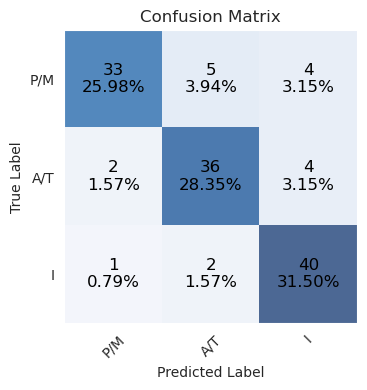

In [25]:
model.model.evaluate(train_generator)
model.model.evaluate(val_generator)
model.model.evaluate(test_generator)

pred = model.model.predict(test_generator).round().astype(int)

print(
    classification_report(
        test_generator.img_labels, [test_generator.oh2class(p) for p in pred], 
        target_names=test_generator.CLASS_NAMES,
        zero_division=0
    )
)

cf_matrix = confusion_matrix(
   test_generator.img_labels, [test_generator.oh2class(p) for p in pred]
)

plt.figure(figsize=(12, 12))
vis.plot_confusion_matrix(cf_matrix)

In [32]:
print(len(unlabeled_generator))

31543


In [33]:
pseudo_labeling(
    model, unlabeled_generator,
    threshold=.9, verbose=1
)

Pseudo-labeling results
Pseudo-labels: 29682
Pseudo-labels distribution: [  194  2623 26865]
Undersampling results
Pseudo-labels: 582
Pseudo-labels distribution: [194 194 194]


In [3]:
pseudo_images_path = v.data_path + 'CellDivision/images_unlabeled/'
pm_path = v.data_path + 'CellDivision/images_unlabeled/prophase_metaphase/'
at_path = v.data_path + 'CellDivision/images_unlabeled/anaphase_telophase/'
i_path = v.data_path + 'CellDivision/images_unlabeled/interphase/'

pseudo_labels = pd.read_csv(
    v.data_path + 'CellDivision/undersampled/pseudo_labels.csv'
)
print(pseudo_labels.shape)
pseudo_labels.head()

(582, 2)


,id,label
0,0402_E2_104376.tif,0
1,0403_E2_9452.tif,0
2,0403_E2_36011.tif,0
3,0806_E6_50763.tif,0
4,0403_E2_23106.tif,0


For the three classes, we are going to create a folder with the pseudo-labeled images.

In [35]:
for id, label in zip(pseudo_labels['id'], pseudo_labels['label']):
    try:
        out_path = pm_path if label == 0 else at_path if label == 1 else i_path
        os.rename(
            pseudo_images_path + id,
            out_path + id
        )
    except:
        print(f'Error with {id}')

Annotations
---
582 pseudo-labeled images | 194 per class

4 professionals to annotate 437 images each (We want to have 3 annotations per image to make a consensus)

Each professional will have the same proportion of images from each class.

Folder division:
- Miguel: 1-437
- Miquel: 146-582
- Cris: 1-145 | 292-582
- Irene: 1-291 | 438-582

1 excel file per professional with the annotations of the images and an associated folder with the images. 

In [4]:
pm_path = v.data_path + 'CellDivision/images_pseudo_labeled/prophase_metaphase/'
at_path = v.data_path + 'CellDivision/images_pseudo_labeled/anaphase_telophase/'
i_path = v.data_path + 'CellDivision/images_pseudo_labeled/interphase/'
pseudo_labels_path = v.data_path + 'CellDivision/images_pseudo_labeled/pseudo_labels.csv'

In [4]:
pseudo_labels = pd.read_csv(pseudo_labels_path)
pseudo_labels.head()

,id,label
0,0402_E2_104376.tif,0
1,0403_E2_9452.tif,0
2,0403_E2_36011.tif,0
3,0806_E6_50763.tif,0
4,0403_E2_23106.tif,0


In [5]:
aux = pseudo_labels['id']

miguel_csv = aux.iloc[:437]
miquel_csv = aux.iloc[145:]
cris_csv = pd.concat([aux.iloc[:145], aux.iloc[291:]])
irene_csv = pd.concat([aux.iloc[:291], aux.iloc[437:]])

print(miguel_csv.shape, miquel_csv.shape, cris_csv.shape, irene_csv.shape)

(437,) (437,) (436,) (436,)


In [42]:
miguel_csv.to_csv(v.data_path + 'CellDivision/images_pseudo_labeled/Miguel/miguel.csv', index=False)
miquel_csv.to_csv(v.data_path + 'CellDivision/images_pseudo_labeled/Miquel/miquel.csv', index=False)
cris_csv.to_csv(v.data_path + 'CellDivision/images_pseudo_labeled/Cris/cris.csv', index=False)
irene_csv.to_csv(v.data_path + 'CellDivision/images_pseudo_labeled/Irene/irene.csv', index=False)

Copy corresponding images to the folders

In [8]:
miguel_path = v.data_path + 'CellDivision/images_pseudo_labeled/Miguel/images/'
miquel_path = v.data_path + 'CellDivision/images_pseudo_labeled/Miquel/images/'
cris_path = v.data_path + 'CellDivision/images_pseudo_labeled/Cris/images/'
irene_path = v.data_path + 'CellDivision/images_pseudo_labeled/Irene/images/'

pm_path = v.data_path + 'CellDivision/images_pseudo_labeled/prophase_metaphase/'
at_path = v.data_path + 'CellDivision/images_pseudo_labeled/anaphase_telophase/'
i_path = v.data_path + 'CellDivision/images_pseudo_labeled/interphase/'

for id in miguel_csv:
    label = pseudo_labels[pseudo_labels['id'] == id]['label'].values[0]
    out_path = pm_path if label == 0 else at_path if label == 1 else i_path
    img = imaging.read_image(out_path + id)
    imaging.save_prediction(img, miguel_path + id)
    
for id in miquel_csv:
    label = pseudo_labels[pseudo_labels['id'] == id]['label'].values[0]
    out_path = pm_path if label == 0 else at_path if label == 1 else i_path
    img = imaging.read_image(out_path + id)
    imaging.save_prediction(img, miquel_path + id)
    
for id in cris_csv:
    label = pseudo_labels[pseudo_labels['id'] == id]['label'].values[0]
    out_path = pm_path if label == 0 else at_path if label == 1 else i_path
    img = imaging.read_image(out_path + id)
    imaging.save_prediction(img, cris_path + id)
    
for id in irene_csv:
    label = pseudo_labels[pseudo_labels['id'] == id]['label'].values[0]
    out_path = pm_path if label == 0 else at_path if label == 1 else i_path
    img = imaging.read_image(out_path + id)
    imaging.save_prediction(img, irene_path + id)